# Imort libraries

In [285]:
!brew install libomp

==> Downloading https://ghcr.io/v2/homebrew/core/libomp/manifests/12.0.0
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libomp/blobs/sha256:fe1e5c0fa8f
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring libomp--12.0.0.big_sur.bottle.tar.gz
🍺  /usr/local/Cellar/libomp/12.0.0: 9 files, 1.5MB


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import keras
import tensorflow
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Input
from tensorflow.python.keras import regularizers
from keras.models import Model
import lightgbm as lgbm

# Import data & label data

In [3]:
#Import data and label data
frauds = pd.read_csv('data/frauds.csv')
nonfrauds = pd.read_csv('data/nonfrauds.csv')

frauds['user_transaction_time'] = pd.to_datetime(frauds['user_transaction_time'])
frauds['date'] = frauds['user_transaction_time'].dt.date

nonfrauds['user_transaction_time'] = pd.to_datetime(nonfrauds['user_transaction_time'])
nonfrauds['date'] = nonfrauds['user_transaction_time'].dt.date

frauds['is_fraud'] = 1
nonfrauds['is_fraud'] = 0

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Sampling for each day by taking 1% of good transactions and 100% of frauds

frauds_date = sorted(list(set(frauds['date'])))
nonfraud = pd.DataFrame()

for date in frauds_date:
    dftemp = nonfrauds.loc[nonfrauds['date'] == date]
    dftemp = dftemp.sample(frac = 0.02, random_state = 0)
    nonfraud = nonfraud.append(dftemp)

df = frauds.append(nonfraud)

In [5]:
df

,key,user_transaction_time,channel,transaction_risk_score,processing_type,cc_amount,ledger_balance,cc_acceptor_state,acceptor_state,cc_acceptor_country,cardholder_presence,card_presence,partial_approval_capable,pin_present,date,is_fraud
0,9d851f1b-00b3-4b02-9494-beda8866d6f7,2020-12-29 16:13:49+00:00,ECOMMERCE,82.0,MANUAL,14.99,134.91,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
1,dc13ebc6-a527-46d0-b424-6642d47c8a11,2020-12-29 16:13:32+00:00,ECOMMERCE,82.0,MANUAL,14.99,359.76,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
2,5e8f4d8f-a720-4a3d-ac55-f8953db3b527,2020-12-29 16:13:13+00:00,ECOMMERCE,82.0,MANUAL,14.99,419.72,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
3,74e6ff6d-f341-4300-8cac-30ab9e5ed5cf,2020-12-29 16:12:56+00:00,ECOMMERCE,82.0,MANUAL,14.99,149.90,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
4,c63d2508-f935-4092-bde1-434e1acbd0ef,2020-12-29 16:12:38+00:00,ECOMMERCE,82.0,MANUAL,14.99,164.89,NaN,NaN,HK,0.0,0.0,0.0,False,2020-12-29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973141,2a02da06-f749-4487-a3fe-0b8cea967f1c,2020-12-29 22:39:38+00:00,ECOMMERCE,3.0,CARD_ON_FILE,71.74,366.89,FL,12,US,0.0,0.0,0.0,False,2020-12-29,0
274308,c8fdbf82-51ae-4825-a6d4-dc8971cb5766,2020-12-29 00:47:18+00:00,ECOMMERCE,3.0,MANUAL,22.20,16064.28,AR,5,US,0.0,0.0,0.0,False,2020-12-29,0
701812,8dbe69a8-04cc-40be-a19f-43128a86420c,2020-12-29 16:26:22+00:00,OTHER,24.0,CHIP,20.00,763.38,CA,6,US,1.0,1.0,1.0,False,2020-12-29,0
273846,a07b0828-c909-4a7e-901d-c169cde8cd18,2020-12-29 08:09:59+00:00,ECOMMERCE,2.0,MANUAL,10.66,15931.11,AR,5,US,0.0,0.0,0.0,False,2020-12-29,0


# Data Exploration

Percentage of non frauds: 4.989344365049518%


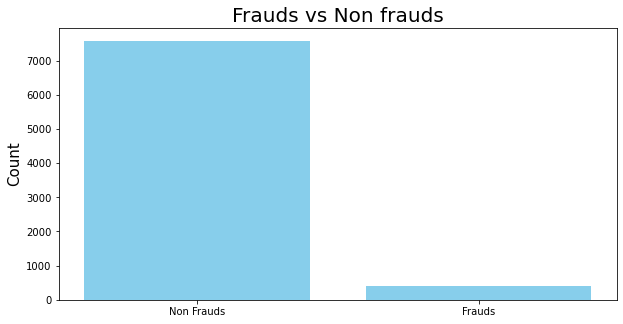

In [4]:
xaxis = ['Non Frauds', 'Frauds']
yaxis = list(df.is_fraud.value_counts())
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color='skyblue')
plt.title("Frauds vs Non frauds", fontsize = 20)
plt.ylabel('Count', fontsize = 15)
print("Percentage of non frauds: " + str(df.is_fraud.value_counts(1)[1]*100) + "%")

Text(0, 0.5, 'Count of Non Frauds')

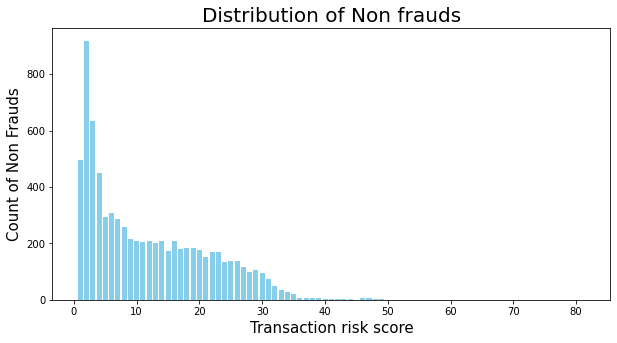

In [5]:
grpby_df = nonfraud.groupby(['transaction_risk_score']).count()
xaxis = list(grpby_df.index)
yaxis = list(grpby_df['key'])
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color='skyblue')
plt.title('Distribution of Non frauds', fontsize=20)
plt.xlabel(r'Transaction risk score',fontsize=15)
plt.ylabel(r'Count of Non Frauds', fontsize=15)

Text(0, 0.5, 'Count of Frauds')

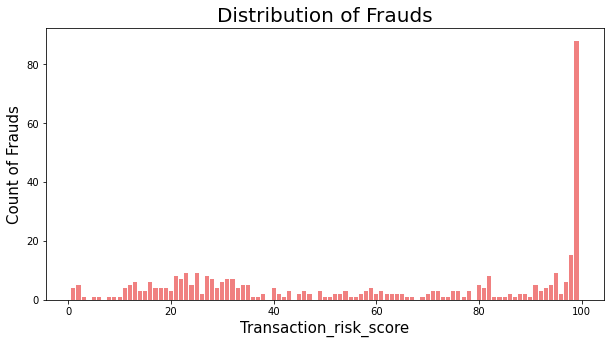

In [6]:
grpby_df = frauds.groupby(['transaction_risk_score']).count()
xaxis = list(grpby_df.index)
yaxis = list(grpby_df['key'])
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color='lightcoral')
plt.title('Distribution of Frauds', fontsize=20)
plt.xlabel(r'Transaction_risk_score',fontsize=15)
plt.ylabel(r'Count of Frauds', fontsize=15)

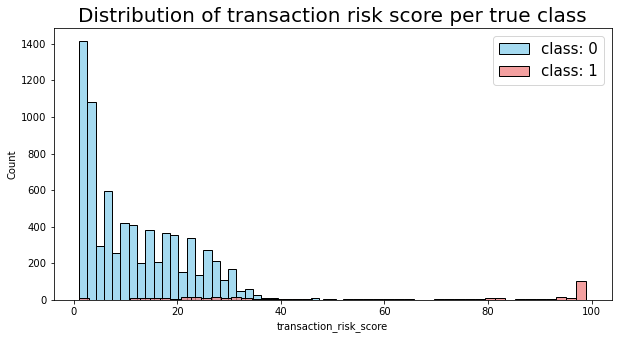

In [7]:
p0 = df[df['is_fraud'] == 0]['transaction_risk_score']
p1 = df[df['is_fraud'] == 1]['transaction_risk_score']

plt.figure(figsize=(10,5))
sns.histplot(p0, kde=False, bins=50, color='skyblue')
sns.histplot(p1, kde=False, bins=50, color='lightcoral')

plt.title("Distribution of transaction risk score per true class", fontsize=20)
plt.legend(["class: 0", "class: 1"], fontsize = 15)
plt.show()

# Preprocessing

## Fill in NA's

In [8]:
df['transaction_risk_score'] = df['transaction_risk_score'].fillna(df['transaction_risk_score'].mean())
df['channel'] = df['channel'].fillna('OTHER')
df['processing_type'] = df['processing_type'].fillna('UNKNOWN')
df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
    'partial_approval_capable']] = df[['cc_amount','ledger_balance','cardholder_presence','card_presence',
                                       'partial_approval_capable']].fillna(0)
df['cc_acceptor_state'] = df['cc_acceptor_state'].fillna('UNKNOWN')

## Encode categorical variables and create new data frame from those

In [9]:
cat_cols = ['channel','processing_type','cc_acceptor_state','cc_acceptor_country']
for c in cat_cols:
    df[c] = df[c].astype('category').cat.codes

In [13]:
df2 = df[['transaction_risk_score','cc_amount','ledger_balance','cardholder_presence','card_presence', 'date',
          'partial_approval_capable','channel','processing_type','cc_acceptor_state','cc_acceptor_country','is_fraud']]
df2 = df2.sort_values(by='date')
#df2 = df2.drop("date",axis=1)

In [14]:
df2

,transaction_risk_score,cc_amount,ledger_balance,cardholder_presence,card_presence,date,partial_approval_capable,channel,processing_type,cc_acceptor_state,cc_acceptor_country,is_fraud
904811,32.000000,10.00,14.66,1.0,1.0,2018-12-25,1.0,2,1,6,20,0
904680,18.000000,7.19,0.00,0.0,0.0,2018-12-25,0.0,0,4,6,20,0
1383059,26.000000,225.36,152.58,0.0,0.0,2018-12-25,0.0,0,4,24,20,0
904802,16.000000,60.98,332.72,0.0,0.0,2018-12-25,0.0,0,4,6,20,0
1704339,26.000000,31.33,49.95,1.0,1.0,2018-12-25,1.0,2,3,47,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...
274230,7.000000,13.52,10551.22,0.0,0.0,2020-12-29,0.0,0,4,3,20,0
1206587,7.000000,59.92,26574.43,0.0,0.0,2020-12-29,0.0,0,4,15,20,0
395,14.176699,76.18,1351.90,0.0,0.0,NaT,0.0,2,5,15,20,1
396,14.176699,620.85,40.93,0.0,0.0,NaT,0.0,2,5,49,20,1


<AxesSubplot:xlabel='date', ylabel='transactions_cnt'>

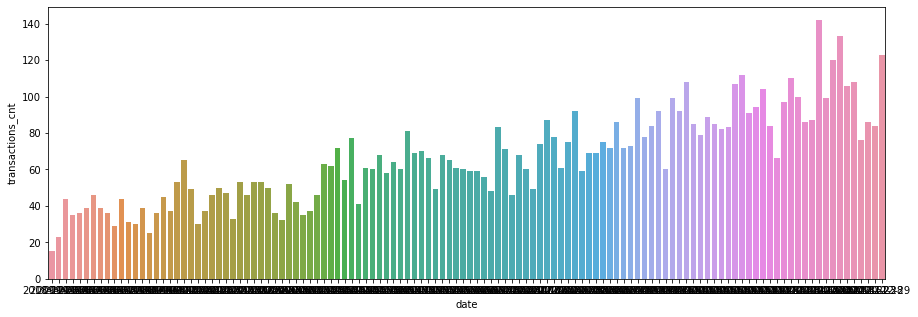

In [409]:
vc = df['user_transaction_time'].dt.date.value_counts().reset_index()
vc.columns = ['date','transactions_cnt']
vc.sort_values(by='date',inplace=True)
plt.figure(figsize=(15, 5))
sns.barplot(x='date',y='transactions_cnt',data=vc)

# Train-test split and standard scaling

In [279]:
training_set, test_set = np.split(df2, [int(.8 *len(df2))])

X_train = training_set.drop("is_fraud",axis=1)
y_train = training_set[['is_fraud']].values.flatten()

X_test = test_set.drop("is_fraud",axis=1)
y_test = test_set[['is_fraud']].values.flatten()

scalar = StandardScaler()
x_train_scale = scalar.fit_transform(X_train)
x_test_scale = scalar.transform(X_test)

In [324]:
X_train

,transaction_risk_score,cc_amount,ledger_balance,cardholder_presence,card_presence,partial_approval_capable,channel,processing_type,cc_acceptor_state,cc_acceptor_country
571074,33.0,39.00,3964.94,0.0,0.0,0.0,0,4,3,20
1383059,26.0,225.36,152.58,0.0,0.0,0.0,0,4,24,20
904802,16.0,60.98,332.72,0.0,0.0,0.0,0,4,6,20
1704339,26.0,31.33,49.95,1.0,1.0,1.0,2,3,47,20
904811,32.0,10.00,14.66,1.0,1.0,1.0,2,1,6,20
...,...,...,...,...,...,...,...,...,...,...
1276138,2.0,11.47,42324.11,0.0,0.0,0.0,0,4,15,20
1818266,17.0,28.99,2608.89,0.0,0.0,0.0,0,4,51,20
1149029,2.0,9.96,1771.04,0.0,0.0,0.0,0,0,12,20
807739,2.0,17.01,2052.49,0.0,0.0,0.0,0,4,6,20


# Random Forest Classifier

In [353]:
%%time

clf = RandomForestClassifier(n_estimators=500, max_depth=25, random_state=0)
clf.fit(x_train_scale,y_train)
pred = clf.predict(x_test_scale)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1473
           1       0.99      0.89      0.94       123

    accuracy                           0.99      1596
   macro avg       0.99      0.94      0.97      1596
weighted avg       0.99      0.99      0.99      1596

CPU times: user 2.44 s, sys: 46.6 ms, total: 2.49 s
Wall time: 2.53 s


# LightGBM

In [347]:
%%time

lgbm_clf = lgbm.LGBMClassifier(
    objective="binary",
    n_estimators=10000,
)
eval_set = [(x_test_scale,y_test)]

lgbm_clf.fit(
    x_train_scale,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=100,
    eval_metric="binary_logloss",
    verbose=-1
)

preds = lgbm_clf.predict(x_test_scale)
preds
print(classification_report(y_test,preds))

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1473
           1       0.96      0.90      0.93       123

    accuracy                           0.99      1596
   macro avg       0.97      0.95      0.96      1596
weighted avg       0.99      0.99      0.99      1596

CPU times: user 694 ms, sys: 25.9 ms, total: 720 ms
Wall time: 410 ms


<ipython-input-354-038b3aa1bdaa>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


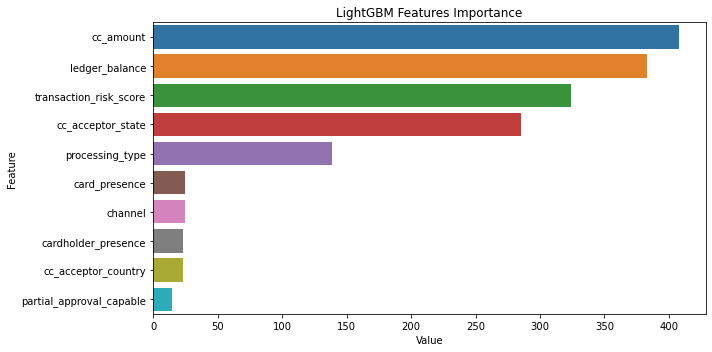

In [354]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance')
plt.tight_layout()
plt.show()

<ipython-input-355-b10a005b1a87>:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


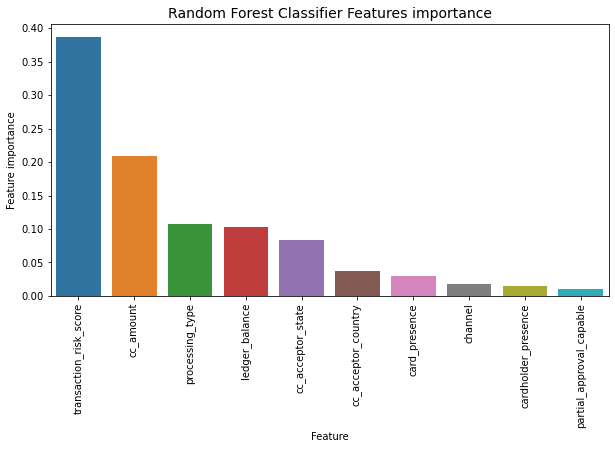

In [355]:
predictors = ['transaction_risk_score','cc_amount','ledger_balance','cardholder_presence','card_presence',
          'partial_approval_capable','channel','processing_type','cc_acceptor_state','cc_acceptor_country']
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (10,5))
plt.title('Random Forest Classifier Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

# ANN

In [385]:
from tensorflow.keras.optimizers import SGD

metrics = [
    'accuracy',
    keras.metrics.Precision(),
    keras.metrics.Recall()
]

epochs=100
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
input_dim = x_train_scale.shape[1]

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

def NN():
    model = keras.Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = metrics)
    
    return model

In [397]:
from keras.callbacks import EarlyStopping
model = NN()
lr_model_history = model.fit(x_train_scale, y_train, validation_data = (x_test_scale, y_test), 
                             batch_size = 32, epochs = epochs, verbose = 1,
                             callbacks=EarlyStopping(monitor='val_loss',patience=10))

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.2629 - accuracy: 0.9455 - precision_4: 0.5907 - recall_4: 0.2864 - val_loss: 0.2321 - val_accuracy: 0.9229 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1297 - accuracy: 0.9572 - precision_4: 0.7500 - recall_4: 0.0109 - val_loss: 0.1225 - val_accuracy: 0.9267 - val_precision_4: 1.0000 - val_recall_4: 0.0488
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1110 - accuracy: 0.9588 - precision_4: 0.7727 - recall_4: 0.0618 - val_loss: 0.0885 - val_accuracy: 0.9348 - val_precision_4: 0.9130 - val_recall_4: 0.1707
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.9635 - precision_4: 0.8281 - recall_4: 0.1927 - val_loss: 0.0698 - val_accuracy: 0.9825 - val_precision_4: 0.9612 - val_recall_4: 0.8049
Epoch 5/100
200/200 [==============================] - 0s 2m

200/200 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9770 - precision_4: 0.8200 - recall_4: 0.5964 - val_loss: 0.0343 - val_accuracy: 0.9912 - val_precision_4: 0.9739 - val_recall_4: 0.9106
Epoch 37/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0689 - accuracy: 0.9787 - precision_4: 0.8677 - recall_4: 0.5964 - val_loss: 0.0354 - val_accuracy: 0.9912 - val_precision_4: 0.9739 - val_recall_4: 0.9106
Epoch 38/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9776 - precision_4: 0.8587 - recall_4: 0.5745 - val_loss: 0.0350 - val_accuracy: 0.9912 - val_precision_4: 0.9739 - val_recall_4: 0.9106
Epoch 39/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0688 - accuracy: 0.9792 - precision_4: 0.8550 - recall_4: 0.6218 - val_loss: 0.0340 - val_accuracy: 0.9912 - val_precision_4: 0.9739 - val_recall_4: 0.9106
Epoch 40/100
200/200 [==============================] - 0s 2ms/step - loss: 0

In [398]:
print("new")
print('accuracy: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[1]))
print('precision: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[2]))
print('recall: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[3]))

new
accuracy: 0.9912280440330505
precision: 0.9739130139350891
recall: 0.9105691313743591


In [326]:
print('accuracy: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[1]))
print('precision: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[2]))
print('recall: ' + str(model.evaluate(x_test_scale,y_test, verbose=0)[3]))

accuracy: 0.9959642291069031
precision: 0.9638554453849792
recall: 0.6722689270973206


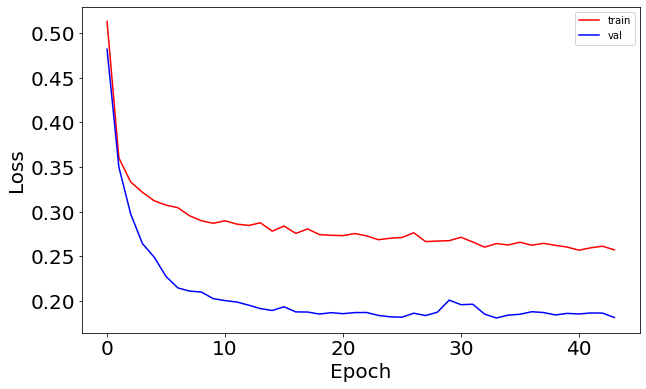

In [399]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

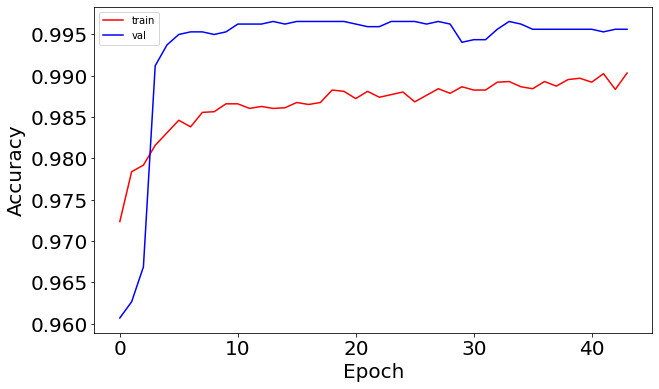

In [400]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)